In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

In [2]:
groq_api_key  = os.getenv("GROQ_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Chatbot With Messages Summarization"

In [3]:
model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [4]:
import sqlite3

# in memory
conn = sqlite3.connect(":memory:", check_same_thread=False)

In [5]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file state_db already exists.
Error occurred while processing: state_db.


In [6]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

## **Our previous chatbot code**

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState



class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

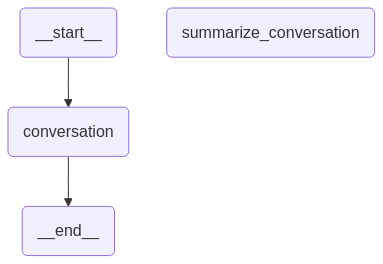

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! How's your day going so far? What's on your mind? Want to chat about something in particular or just shoot the breeze? I'm here to listen!
================================== Ai Message ==================================

Your name is Lance! We just started chatting a minute ago, and you told me that. How can I help you today, Lance?
================================== Ai Message ==================================

Go Niners! The San Francisco 49ers have a rich history and a loyal fan base. Who's your favorite player, past or present? Are you a fan of the current team or do you have a favorite player from the past, like Joe Montana or Jerry Rice?


In [10]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='cbf1d8e6-daed-451c-8d77-f564ba5abae7'), AIMessage(content="Hi Lance! How's your day going so far? What's on your mind? Want to chat about something in particular or just shoot the breeze? I'm here to listen!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 14, 'total_tokens': 49, 'completion_time': 0.075574148, 'prompt_time': 0.002744224, 'queue_time': 0.9328451750000001, 'total_time': 0.078318372}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'stop', 'logprobs': None}, id='run--a710b6e0-e453-4884-a1fb-00685144a1e3-0', usage_metadata={'input_tokens': 14, 'output_tokens': 35, 'total_tokens': 49}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='1b3f7fd3-0b2d-4d3e-bc15-94601bef5185'), AIMessage(content='Your n

## now its work as offline mode also because my memory saved in the local storage.